# Training - Cornell Dataset

## Imports

In [1]:
from tensorflow.keras import regularizers, layers, losses, preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from helper_fxns import remove_url, clean_text
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
import pandas as pd
import numpy as np
import os, shutil
import string
import nltk
import sys
import re

import pydot

## Checking GPU

In [2]:
if tf.test.gpu_device_name():
  print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
  print('Please install GPU version of TF')

Default GPU Device: /device:GPU:0Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB




2022-11-06 11:37:35.318696: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 11:37:35.318792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-06 11:37:35.319695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-06 11:37:35.319705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Converting the Cornell Dataset into DataFrames

The codes in this subsection only needs to be run once, as the data has already been combined into 1 csv file and is saved. Hence, the next time round, this section can just be skipped and the .csv file can just be loaded in directly.

In [3]:
def create_df(tag):
    DIR = os.path.join("review_polarity/txt_sentoken/", tag)
    contents = os.listdir(DIR)

    text = []

    if ".DS_Store" in contents:
        contents.remove(".DS_Store")

    for file in contents:
        file_path = os.path.join(DIR, file)
        with open(file_path) as f:
            lines = f.read()
        lines = lines.replace("\n", " ")
        text.append(lines)
    
    num_texts = len(contents)
    label = [tag] * num_texts

    if len(text) == len(label):
        print("INFO: Correct Length of Text and Label!")
    else:
        print(f"ERROR: Mismatch of Lengths Text : {len(text)}, Label : {len(label)}")
        sys.exit(1)

    data_dict = {"text" : text, "sentiment" : label}

    data_df = pd.DataFrame(data_dict)
    return data_df

In [4]:
pos_df = create_df('pos')
neg_df = create_df('neg')
pos_df.head()

INFO: Correct Length of Text and Label!
INFO: Correct Length of Text and Label!


,text,sentiment
0,assume nothing . the phrase is perhaps one of...,pos
1,plot : derek zoolander is a male model . he i...,pos
2,i actually am a fan of the original 1961 or so...,pos
3,a movie that's been as highly built up as the ...,pos
4,""" good will hunting "" is two movies in one : ...",pos


In [5]:
neg_df.head()

,text,sentiment
0,bad . bad . bad . that one word seems to pre...,neg
1,isn't it the ultimate sign of a movie's cinema...,neg
2,""" gordy "" is not a movie , it is a 90-minute-...",neg
3,disconnect the phone line . don't accept the ...,neg
4,when robert forster found himself famous again...,neg


### Concatenating the DataFrames

In [6]:
df = pd.concat([pos_df, neg_df], ignore_index=True)
df

,text,sentiment
0,assume nothing . the phrase is perhaps one of...,pos
1,plot : derek zoolander is a male model . he i...,pos
2,i actually am a fan of the original 1961 or so...,pos
3,a movie that's been as highly built up as the ...,pos
4,""" good will hunting "" is two movies in one : ...",pos
...,...,...
1995,synopsis : when a meteorite crashlands in the ...,neg
1996,it's now the anniversary of the slayings of ju...,neg
1997,coinciding with the emerging popularity of mov...,neg
1998,and now the high-flying hong kong style of fil...,neg


### Writing the DataFrame into a csv

In [7]:
df.to_csv('cornell_v2_polarity.csv', index=False)

## Loading the Datasets

The Crawled Dataset acts as our test dataset, while the Cornell Polarity Dataset makes up our training and validation set. Hence, the test set should also go through tokenization and other preprocessing steps that the training and vaidation set go through in order to make it a fair evaluation. 

The Crawled Dataset has been processed to look similar to the Cornell Polarity Dataset, eg: Changing mapping the labels as follows:

{'POSITIVE' : 'pos', 'NEGATIVE' : 'neg'}

The Test Dataset has already gone through removing the URLs and Punctuation. The code for this can be found in **processing_datasets_test.ipynb**

### Crawled Dataset (Test)

NOTE: While loading the Crawled Dataset, some of the decimal numbers in the text might be read as floats, this would give problems in tokenizaiton, hence, we ensure that the whole dataframe contains the str type by adding on the method .astype(str) while importing the csv file.

In [108]:
test_data = pd.read_csv('test_dataset.csv').astype(str)
test_data.head()

,text,sentiment
0,weaknesses are minor the feel and layout the r...,neg
1,many our disney movies play this dvd player,neg
2,player has problem with duallayer dvd such ali...,neg
3,know the saying you get what you pay for but t...,neg
4,will never purchase apex again,neg


### Cornell Polarity Dataset (Training + Validation)

In [26]:
df = pd.read_csv('cornell_polarity_combined.csv')
df.head()

,text,sentiment
0,assume nothing . the phrase is perhaps one of...,pos
1,plot : derek zoolander is a male model . he i...,pos
2,i actually am a fan of the original 1961 or so...,pos
3,a movie that's been as highly built up as the ...,pos
4,""" good will hunting "" is two movies in one : ...",pos


## Preprocessing

### Helper Functions to Remove URL and Clean Text

Importing the remove_url and clean_text fucntions to remove any URL in the text and to remove punctuations in the text. Only for the Cornell Dataset as the Test Dataset has alreeady gone through this.

In [27]:
df['text'] = df['text'].apply(remove_url)
df['text'] = df['text'].apply(clean_text)
df.head()

,text,sentiment
0,assume nothing the phrase perhaps one the most...,pos
1,plot derek zoolander male model also very dumb...,pos
2,actually fan the original liveactiondisney fli...,pos
3,movie thats been highly built the truman show ...,pos
4,good will hunting two movies one independent t...,pos


In [28]:
print("Number of texts in each of the Classes: ")
df['sentiment'].value_counts()

Number of texts in each of the Classes: 


pos    1000
neg    1000
Name: sentiment, dtype: int64

By looking at the value counts, we can see that the dataset is balanced and there is an equal distribution between Positive and Negative sentiments.

## Tokenization

Updates a list on vocabulary based on the text. It kind of creates its Vocabulary. This is important before converting texts into sequences. 

In [29]:
#Instantiating Tokenizer on Cornell and Crawled Dataset
num_words = 1000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(df['text'].tolist())
tokenizer.fit_on_texts(test_data['text'].tolist())

### Splitting Training Sets into Different Splits

In [31]:
#Prior to splitting
print(f"Length of dataset: {len(df)}")
print(f"Length of Train: {int(0.8 * len(df))}")
print(f"Length of Valid: {int(0.2 * len(df))}")
print(f"Length of Test: {len(test_data)}")

Length of dataset: 2000
Length of Train: 1600
Length of Valid: 400
Length of Test: 3771


In [32]:
#splitting into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(df['text'].tolist(), 
                                                  df['sentiment'].tolist(), 
                                                  test_size=0.2, stratify=df['sentiment'].tolist(),
                                                  random_state=0)

In [35]:
X_test = test_data['text'].tolist()
y_test = test_data['sentiment'].tolist()

In [37]:
print(f"Length of Train : {len(X_train)}")
print(f"Length of Valid : {len(X_valid)}")
print(f"Length of Test : {len(X_test)}")

Length of Train : 1600
Length of Valid : 400
Length of Test : 3771


In [39]:
#getting the class distribution
print("Class Distributions:")
print(f"Train: {str(Counter(y_train))}")
print(f"Valid: {str(Counter(y_valid))}")
print(f"Test: {str(Counter(y_test))}")

Class Distributions:
Train: Counter({'neg': 800, 'pos': 800})
Valid: Counter({'neg': 200, 'pos': 200})
Test: Counter({'pos': 2405, 'neg': 1366})


### Converting Texts to Sequences and Storing them in Arrays

Assigning an index to each word in the text sample. Do note that for the Tokenization, 0 is not assigned to any word, it is instead assigned to any new/unknown word that is not present in the vocabulary.

In [40]:
#Converts the texts to sequences and stores it in an array
x_train = np.array(tokenizer.texts_to_sequences(X_train))
x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
x_test = np.array(tokenizer.texts_to_sequences(X_test))

/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1528/3986626980.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(tokenizer.texts_to_sequences(X_train))
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1528/3986626980.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array(tokenizer.texts_to_sequences(X_valid))
/var/folders/54/f2chvxk17fd0vhl03xl62d_80000gn/T/ipykernel_1528/3986626980.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of 

## Padding the Sequences

### Finding the Longest Word Sequence

This is important as this kind of defines what the shape of the input should be.

In [41]:
#finding the longest word sequence
train_num_words_text = pd.DataFrame(X_train, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_train = max(train_num_words_text)

valid_num_words_text = pd.DataFrame(X_valid, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_valid = max(valid_num_words_text)

test_num_words_text = pd.DataFrame(X_test, columns=['text'])['text'].apply(lambda x:len(str(x).split()))
max_len_test = max(test_num_words_text)

print('Longest Sentence in terms of words in Train: ', max_len_train)
print('Longest Sentence in terms of words in Valid: ', max_len_valid)
print('Longest Sentence in terms of words in Test: ', max_len_test)

Longest Sentence in terms of words in Train:  1512
Longest Sentence in terms of words in Valid:  1880
Longest Sentence in terms of words in Test:  81


Therefore, in order to account for the all the splits, we set the shape of the input as 1885.

In [42]:
MAXLEN = 1885

In [43]:
x_train = pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_valid = pad_sequences(x_valid, padding='post', maxlen=MAXLEN)
x_test = pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [44]:
x_train[0]

array([509, 534, 889, ...,   0,   0,   0], dtype=int32)

In this section, we extended the list of the sequences to the MAXLEN, in order to standardise across te splits.

## Encoding the Labels

In [45]:
#Instantiating the LabelEncoder
le = LabelEncoder()

In [46]:
#Encoding the train labels
train_labels = le.fit_transform(y_train)
valid_labels = le.transform(y_valid)
test_labels = le.transform(y_test)

#Converting the encoded train labels into categorical form and then storing them as an array
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [47]:
#Listing out the classes
list(le.classes_)

['neg', 'pos']

In [54]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

From the le.classes_ we get to know the order in which the columns represent the classes in the labels array. Dince the output of le.classes_ is [neg, pos], the first column in the test_labels represent the neg class and the second column pos class. Hence, in the test_labels the first 3 rows represent neg class as the value in the first column is 1 and so on. This applies to all the labels.

## Creating our own Tensorflow Dataset

In [55]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

2022-10-29 16:06:24.775814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-29 16:06:24.775837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [59]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Train dataset ====
tf.Tensor([509 534 889 ...   0   0   0], shape=(1885,), dtype=int32) tf.Tensor([1. 0.], shape=(2,), dtype=float32)
======Validation dataset ====
tf.Tensor([  2  44 205 ...   0   0   0], shape=(1885,), dtype=int32) tf.Tensor([1. 0.], shape=(2,), dtype=float32)
======Test dataset ====
tf.Tensor([  1  11 977 ...   0   0   0], shape=(1885,), dtype=int32) tf.Tensor([1. 0.], shape=(2,), dtype=float32)


## CNN Model Creation

In [61]:
#Initialsing Parameters
max_features = 1000
embedding_dim = 64
sequence_length = MAXLEN
epochs = 100
batch_size = 32

In [81]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length,
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(2, activation='sigmoid',
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))

In [82]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1885, 64)          64064     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1883, 128)         24704     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 89,026
Trainable params: 89,026
Non-trainable params: 0
__________________________________________________

In [83]:
#creating callbacks - early stopping and storing best model checkpoint 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=10)

checkpoint_filepath = '/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/weights/try1_best_epoch{epoch}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_categorical_accuracy',
    save_best_only=True)

In [84]:
#compiling the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])


## Training

In [85]:
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs=epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

model.save('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/models/try1_final_model.h5')

Epoch 1/100


/Users/sankeerthana/miniforge3/envs/ml/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4882: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-10-29 16:29:38.460209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 7s 425ms/step - loss: 0.7632 - categorical_accuracy: 0.5087 - val_loss: 0.7563 - val_categorical_accuracy: 0.6025


2022-10-29 16:29:44.686861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
13/13 [==============================] - 6s 465ms/step - loss: 0.7494 - categorical_accuracy: 0.5631 - val_loss: 0.7466 - val_categorical_accuracy: 0.5550
Epoch 3/100
13/13 [==============================] - 6s 438ms/step - loss: 0.7356 - categorical_accuracy: 0.5975 - val_loss: 0.7375 - val_categorical_accuracy: 0.5250
Epoch 4/100
13/13 [==============================] - 6s 459ms/step - loss: 0.7229 - categorical_accuracy: 0.6337 - val_loss: 0.7274 - val_categorical_accuracy: 0.7425
Epoch 5/100
13/13 [==============================] - 7s 504ms/step - loss: 0.7104 - categorical_accuracy: 0.6700 - val_loss: 0.7156 - val_categorical_accuracy: 0.7225
Epoch 6/100
13/13 [==============================] - 6s 464ms/step - loss: 0.6933 - categorical_accuracy: 0.7225 - val_loss: 0.6998 - val_categorical_accuracy: 0.7325
Epoch 7/100
13/13 [==============================] - 6s 474ms/step - loss: 0.6667 - categorical_accuracy: 0.7506 - val_loss: 0.6752 - val_categorical_accuracy: 0.745

**Try 1**

Model stopped at epoch 30 - with val_categorical_accuracy = 0.7975

### Storing the History File - Future References

In [86]:
with open('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/history/try1_history.txt', 'w') as f:
    f.writelines(str(history.history))

### Saving Model Code

In [98]:
model_code = ["model = tf.keras.Sequential()",
"model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length, embeddings_regularizer = regularizers.l2(0.0005)))", 
"model.add(tf.keras.layers.Conv1D(128,3, activation='relu', kernel_regularizer = regularizers.l2(0.0005),bias_regularizer = regularizers.l2(0.0005))) ",                             
"model.add(tf.keras.layers.GlobalMaxPooling1D())",
"model.add(tf.keras.layers.Dropout(0.5))",
"model.add(tf.keras.layers.Flatten())",
"model.add(tf.keras.layers.Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001),))",
"model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=['CategoricalAccuracy'])"]

In [99]:
with open('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/models/try1_model_code.txt','w') as f:
    f.writelines(str(model_code))

## Performance Visualisation and Analysis

### Accuracy Curves

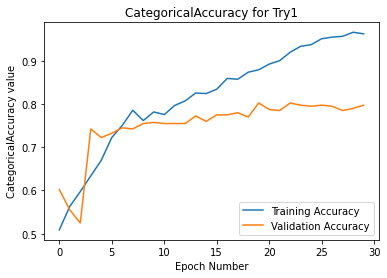

In [95]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('CategoricalAccuracy for Try1')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('Epoch Number')
plt.legend(loc="lower right")
plt.savefig('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/analysis/try1_acc.jpg')
plt.show()

### Loss Curves

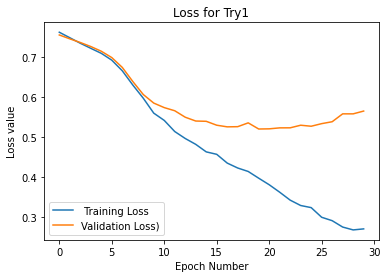

In [96]:
plt.plot(history.history['loss'], label=' Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss)')
plt.title('Loss for Try1')
plt.ylabel('Loss value')
plt.xlabel('Epoch Number')
plt.legend(loc="lower left")
plt.savefig('/Users/sankeerthana/Documents/NTU/YEAR_4/CZ4045/Group_Assignment/NLP-text-classification-CNN/model/analysis/try1_loss.jpg')
plt.show()

## Inference on Test Set

### Predictions

In [100]:
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples


2022-10-29 16:55:45.648656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[0.514233   0.48245162]
 [0.61626524 0.31899962]
 [0.58064246 0.38637403]
 ...
 [0.54303014 0.44320345]
 [0.5551895  0.42817897]
 [0.38954753 0.5872405 ]]


In [119]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = test_data['pred_sentiment'].replace({0 : 'neg', 1 : 'pos'})

In [120]:
test_data

,text,sentiment,pred_sentiment
0,weaknesses are minor the feel and layout the r...,neg,neg
1,many our disney movies play this dvd player,neg,neg
2,player has problem with duallayer dvd such ali...,neg,neg
3,know the saying you get what you pay for but t...,neg,neg
4,will never purchase apex again,neg,neg
...,...,...,...
3766,installed activated and registered nis without...,pos,neg
3767,far the antispam feature seems very good,pos,pos
3768,downloaded trial version computer associates f...,pos,neg
3769,did not have any the installation problems tha...,pos,neg


### Score

In [147]:
gt_label = test_data['sentiment']
pred_label = test_data['pred_sentiment']

In [150]:
correct = 0
wrong = 0

for i in range(len(gt_label)):
    if gt_label[i] == pred_label[i]:
        correct += 1
    else:
        wrong += 1

print("========= RESULT ==========")
print(f"Total : {len(gt_label)}")
print(f"Correct : {correct}")
print(f"Wrong : {wrong}")

print("")

print(f"Accuracy : {(correct/len(gt_label))*100}")

========= RESULT ==========
Total : 3771
Correct : 2106
Wrong : 1665

Accuracy : 55.847255369928405


Accuracy on Test Set is 55.85%

In [151]:
val = ['pos','neg']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=val))

              precision    recall  f1-score   support

         pos       0.82      0.40      0.53      2405
         neg       0.44      0.84      0.58      1366

    accuracy                           0.56      3771
   macro avg       0.63      0.62      0.56      3771
weighted avg       0.68      0.56      0.55      3771

